# List of all models considered

Here SLH driven means the SLH rule is used to find the drive.  This gives a term in both the L and the H operators. Coherently driven means that we have used an equivalence on the master equation level to move the extra term on the L operator to the H operator, finding twice the original added term on H.

The text below describes the qutip output for each model. If it is not present it has not been implemented.

## Pure simulations

### coherently driven Kerr
coherent_kerr_mcdata

### SLH driven Kerr
SLH_kerr_mcdata

### coherently driven 2 Kerrs
coherent_2kerr_mcdata

### SLH driven 2 Kerrs

coherent_2kerr_mcdata_slh
__________________________


## Semiclassical simulations

### coherently driven kerr semiclassically feeding into a second kerr
semi_2kerr_mcdata_lst 

### SLH driven kerr semiclassically feeding into a second kerr

__________________________

## HMM models

### Red(coherently driven Kerr)

markov_coherent_kerr

### Red_{12} (coherently driven 2 Kerrs) -- HMM using operators from both Kerrs
markov_coherent_2kerr

### Red_{2} (coherently driven 2 Kerrs) -- HMM using operators from the second Kerr only
markov_coherent_2kerr2

### Red(coherently driven Kerr) feeding semiclassically into second Kerr
semi_red_mcdata

### Red(  Red(coherently driven Kerr) feeding semiclassically into second Kerr ) 
markov_semi_to_kerr

## Hybrid Model: red (Kerr1) --> kerr 2. Generates a new SLH for each Markov state of Red(sys1), and at each timestep uses the outputs for system 2.
hybrid

In [2333]:
## Some of the code seems to require Python 3

import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [2334]:
from qnet.algebra.operator_algebra import *
from qnet.algebra.circuit_algebra import *
import qnet.algebra.state_algebra as sa
from qnet.circuit_components.displace_cc import Displace

from qnet.algebra.operator_algebra import get_coeffs ### used later to make time-dependent terms from reduced model.

from qutip import *
from scipy import *

import sympy; sympy.init_printing(use_latex="mathjax")
from sympy import sqrt
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import itertools
from imp import reload
import pickle

## Sometimes Macs will have an issue with Matplotlib, this seems to fix it.
## see http://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python

import matplotlib as mil
mil.use('TkAgg')

In [2335]:
import sample_systems

In [2336]:
import build_markov
import warnings
warnings.filterwarnings("ignore")

sys.path.append('./make_quantum_jump_trajectories/')
from mcdata2matfile_or_pkl import mcdata2matfile_or_pkl

## save to a folder

import os
directory_name = "/trajectory_data"
d = (os.getcwd() + directory_name)
try:
    os.stat(d)
except:
    os.mkdir(d)

In [2337]:
def load(name):
    f = open(name,'rb')
    tmp = pickle.load(f)
    f.close()
    return tmp

def save(thing,name):
    f = open(name,'wb')
    pickle.dump(thing,f)
    f.close()

In [2338]:
from scipy.stats import gaussian_kde

## Plot density
def plot_density(x,y,s = 10):
    if len(x) != len(y):
        raise ValueError
    if len(x) > 10000:
        x = x[::len(x)/10000]
        y = y[::len(y)/10000]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig = plt.figure(0,)
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, )

    ax.scatter(x, y, c=z, s=s, edgecolor='')

In [2339]:
def plot_N1_v_N2(mcdata):
    N1,_,_,N2,_,_ = np.concatenate(np.asarray(coherent_2kerr_mcdata.expect), axis = -1)
    plot_density(N1, N2,s = 50)
    plt.xlim(0,14)
    plt.ylim(0,14)

In [2340]:
def make_drive_coeffs(x,p,delta_t):
    def drive_coeff_x(t,args):
        step = int(t / delta_t)
        return x[step]
    def drive_coeff_p(t,args):
        step = int(t / delta_t)
        return p[step]
    return drive_coeff_x,drive_coeff_p

In [2341]:
def make_driven_model(drive_coeff_x,drive_coeff_p):
    ## Hamiltonian due to drive. multiply by 2 to include effects on L.
    a_k = Destroy('1')
    a_k.space.dimension = Nfock
    S = -identity_matrix(2)
    L = [sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k]
    H = 0.
    
    driven_slh= (SLH(S, L, H).toSLH()<< Displace(alpha=1)+cid(1)).toSLH() ## set drive = '1'
    drive_operator_x = (driven_slh.H*2).substitute(params).to_qutip()
    
    driven_slh = (SLH(S, L, H).toSLH()<< Displace(alpha=1j)+cid(1)).toSLH() ## set drive = '1j'
    drive_operator_p = (driven_slh.H*2).substitute(params).to_qutip()
    
    ## non driven kerr
    H0, L0 = KERR_lst[0].substitute(params).HL_to_qutip()
    
    H_driven_num = [H0, 
                [drive_operator_x, drive_coeff_x],
                [drive_operator_p, drive_coeff_p]]
    
    return H_driven_num,L0

In [3713]:
####
Regime = "kerr_bistable_cascade"

## matlab file.
save_mat = False
## pkl file (can be loaded in python) in the same format as above.
save_pkl = True
file_name = "." + directory_name + '/' + Regime

# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")

## bistable regime
if Regime == "kerr_bistable_cascade":
    params = {alpha0 : 22., chi : -10, Delta : 100., kappa_1 : 25, kappa_2 : 25,
              'Ntraj' : 100, 'duration' : 20000., 'Nfock' : 30}
else:
    ## qubit regime
    params = {alpha0 : 10.0, chi : -100, Delta : 1e-10, kappa_1 : 0.5, kappa_2 : 1e-10,
              'Ntraj' : 10, 'duration' : 25000., 'Nfock' : 15}

## These are used later in the simulation
Ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']

Tsim = np.arange(0, duration/1000, 1e-1)
delta_t = Tsim[1] - Tsim[0]

In [3700]:
NUM_KERR = 2
# Construct Kerr SLH
a_lst = [Destroy(str(i)) for i in range(NUM_KERR)]

for a in a_lst:
    a.space.dimension = Nfock

S_lst = [-identity_matrix(2)]*NUM_KERR
L_lst = [[sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k] for a_k in a_lst]
H_lst = [Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k for a_k in a_lst]
KERR_lst = [SLH(S, L, H).toSLH() for S,L,H in zip(S_lst,L_lst,H_lst) ]

In [3701]:
KERR_lst[0]

SLH(Matrix([[-1, 0], [0, -1]]), Matrix([[ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('0', '')))], [ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('0', '')))]]), OperatorPlus(ScalarTimesOperator(chi/2, OperatorTimes(Create(LocalSpace('0', '')), Create(LocalSpace('0', '')), Destroy(LocalSpace('0', '')), Destroy(LocalSpace('0', '')))), ScalarTimesOperator(Delta, OperatorTimes(Create(LocalSpace('0', '')), Destroy(LocalSpace('0', ''))))))

In [3702]:
driven_kerr

SLH(Matrix([[-1, 0], [0, -1]]), Matrix([[OperatorPlus(ScalarTimesOperator(-2*alpha_0, IdentityOperator), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('0', ''))))], [ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('0', '')))]]), OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(2*alpha_0*sqrt(kappa_1), Create(LocalSpace('0', ''))), ScalarTimesOperator(-2*sqrt(kappa_1)*conjugate(alpha_0), Destroy(LocalSpace('0', ''))))), ScalarTimesOperator(chi/2, OperatorTimes(Create(LocalSpace('0', '')), Create(LocalSpace('0', '')), Destroy(LocalSpace('0', '')), Destroy(LocalSpace('0', '')))), ScalarTimesOperator(Delta, OperatorTimes(Create(LocalSpace('0', '')), Destroy(LocalSpace('0', ''))))))

In [3703]:
# driven_slh= (SLH(S, L, H).toSLH()<< Displace(alpha=1)+cid(1)).toSLH() ## set drive = '1'
# drive_operator_x = (driven_slh.H*2).substitute(params).to_qutip()

In [3704]:
# driven_slh

In [3705]:
# KERR_lst[0]

# Coherently Driven Kerr

In [3706]:
## Observables
a = a_lst[0]

In [3707]:
single_psi0 = qutip.tensor(qutip.basis(Nfock, 0))
driven_kerr = (KERR_lst[0] << Displace(alpha=2*alpha0)+cid(1)).toSLH()
single_kerr_obs = tuple([a.dag()*a, a+a.dag(), (a-a.dag())/1j])
single_kerr_obsq = [o.to_qutip(full_space=driven_kerr.space) for o in single_kerr_obs]

In [3708]:
H_num_0, L_num_0 = KERR_lst[0].substitute(params).HL_to_qutip()  ## Undriven
H_num, L_num = driven_kerr.substitute(params).HL_to_qutip()      ## Driven with 2 alpha0

In [3709]:
import copy

In [3710]:
for j in range(Nfock):
    N_op = copy.deepcopy(single_kerr_obsq[0])
    for i in range(Nfock):
        if i != j:
            N_op.data[i,i] = 0
    single_kerr_obsq.append(N_op)

In [3729]:
## generate trajectory
coherent_kerr_mcdata_rho = qutip.mesolve(H_num, single_psi0, Tsim, L_num_0, 
                       single_kerr_obsq, 
                       options=qutip.Odeoptions(store_states=False,average_expect=False,seeds = [1],))

In [ ]:
## generate trajectory
coherent_kerr_mcdata = qutip.mcsolve(H_num, single_psi0, Tsim, L_num_0, 
                       single_kerr_obsq, ntraj=Ntraj, 
                       options=qutip.Odeoptions(store_states=False,average_expect=False,seeds = [1],))

In [ ]:
plt.plot(np.asarray(coherent_kerr_mcdata_rho.expect)[-Nfock:][:,-1])

In [ ]:
plt.plot(np.asarray(coherent_kerr_mcdata.expect)[30][:3].T);

In [ ]:
plt.plot(np.average(np.asarray(coherent_kerr_mcdata.expect),axis=0)[:3].T);

In [ ]:
save(coherent_kerr_mcdata,'coherent_kerr_mcdata')

In [3712]:
coherent_kerr_mcdata = load('coherent_kerr_mcdata')

# SLH Driven Kerr

In [ ]:
SLH_kerr = (KERR_lst[0] << Displace(alpha=alpha0)+cid(1)).toSLH()

In [ ]:
SLH_kerr.L

In [ ]:
SLH_kerr.H

In [ ]:
H_num, L_num  = SLH_kerr.substitute(params).HL_to_qutip()

In [ ]:
## generate trajectory
SLH_kerr_mcdata_rho = qutip.mesolve(H_num, single_psi0, Tsim, L_num, 
                       single_kerr_obsq, 
                       options=qutip.Odeoptions(store_states=False,average_expect=False,seeds = [1],))

In [ ]:
## generate trajectory
SLH_kerr_mcdata = qutip.mcsolve(H_num, single_psi0, Tsim, L_num, 
                       single_kerr_obsq, ntraj=Ntraj, 
                       options=qutip.Odeoptions(store_states=False,average_expect=False,seeds = [1]) )

In [ ]:
plt.plot(np.asarray(SLH_kerr_mcdata_rho.expect)[-Nfock:][:,-1])

In [ ]:
# start_from = 20000

In [ ]:
# N_proj_slh = np.asarray((np.matrix(range(15))
#                          * np.asmatrix(np.concatenate(np.asarray(SLH_kerr_mcdata.expect)[:,:,start_from:],axis=-1)[-15:])))[0]

In [2991]:
# N_proj_co = np.asarray((np.matrix(range(15))
#                          * np.asmatrix(np.concatenate(np.asarray(coherent_kerr_mcdata.expect)[:,:,start_from:],axis=-1)[-15:])))[0]

In [2992]:
# plt.figure(figsize=(10,10));
# # plt.xlim(0,12)
# plt.hist(N_proj_co,bins=200, alpha = 0.5);
# plt.hist(N_proj_slh,bins=200,alpha = 0.5);

In [2993]:
save(SLH_kerr_mcdata,'SLH_kerr_mcdata')

In [2994]:
SLH_kerr_mcdata = load('SLH_kerr_mcdata')

# Comparing SLH Driven versus Coherent Driven

In [2995]:
min_step = 100

In [2996]:
N1_co = np.concatenate(np.asarray(coherent_kerr_mcdata.expect)[:,0,min_step:],axis=-1)
N1_slh = np.concatenate(np.asarray(SLH_kerr_mcdata.expect)[:,0,min_step:],axis=-1)

(0, 20)

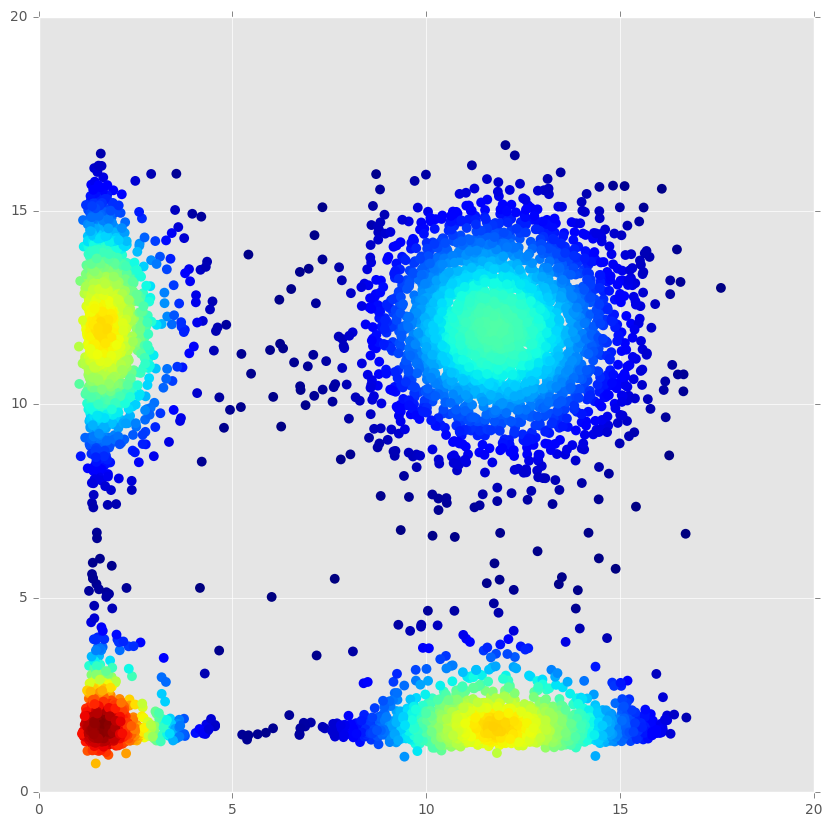

In [3044]:
plot_density(N1_co,N1_slh,s = 50)
plt.xlim(0,20)
plt.ylim(0,20)

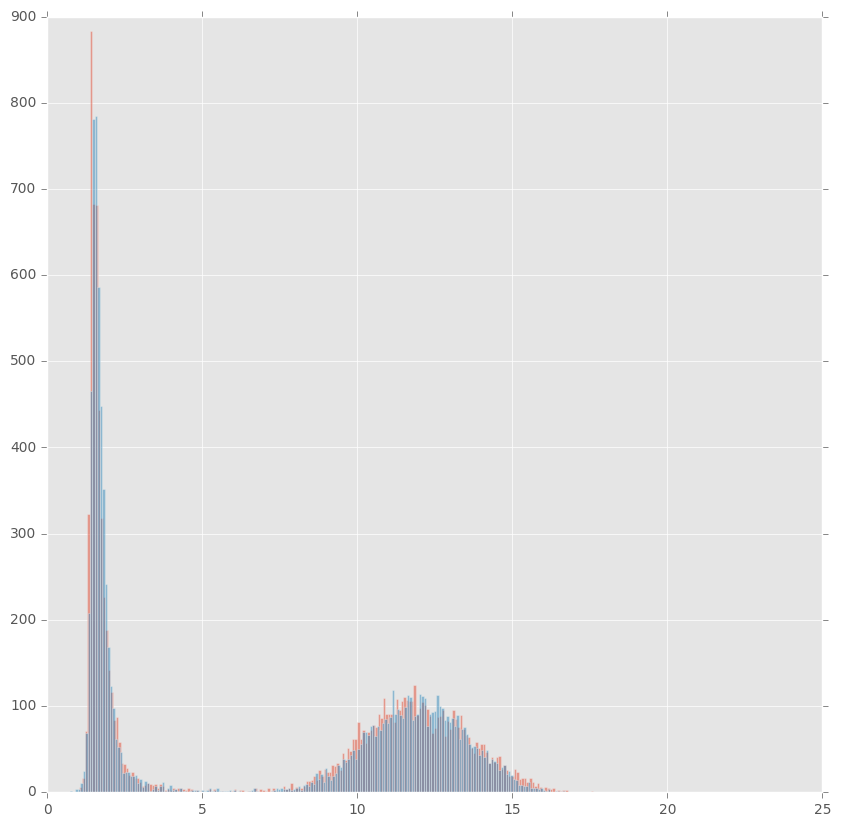

In [3017]:
plt.figure(figsize=(10,10));
plt.xlim(0,25)
plt.hist(N1_co,bins=200, alpha = 0.5);
plt.hist(N1_slh,bins=200,alpha = 0.5);

# coherently driven 2 Kerrs

In [2999]:
double_psi0 = qutip.tensor(*[qutip.basis(Nfock, 0)]*2)
undriven_double_kerr = (KERR_lst[1]  << KERR_lst[0]).toSLH()
driven_double_kerr = (KERR_lst[1]  << KERR_lst[0] << Displace(alpha=2*alpha0)+cid(1)).toSLH()

In [3000]:
undriven_double_kerr.L

Matrix([[OperatorPlus(ScalarTimesOperator(-sqrt(kappa_1), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('1', ''))))], [OperatorPlus(ScalarTimesOperator(-sqrt(kappa_2), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('1', ''))))]])

In [3001]:
driven_double_kerr.L

Matrix([[OperatorPlus(ScalarTimesOperator(2*alpha_0, IdentityOperator), ScalarTimesOperator(-sqrt(kappa_1), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('1', ''))))], [OperatorPlus(ScalarTimesOperator(-sqrt(kappa_2), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('1', ''))))]])

In [3002]:
driven_double_kerr

SLH(Matrix([[1, 0], [0, 1]]), Matrix([[OperatorPlus(ScalarTimesOperator(2*alpha_0, IdentityOperator), ScalarTimesOperator(-sqrt(kappa_1), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('1', ''))))], [OperatorPlus(ScalarTimesOperator(-sqrt(kappa_2), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('1', ''))))]]), OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(-2*alpha_0, OperatorPlus(ScalarTimesOperator(-sqrt(kappa_1), Create(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_1), Create(LocalSpace('1', ''))))), ScalarTimesOperator(2*conjugate(alpha_0), OperatorPlus(ScalarTimesOperator(-sqrt(kappa_1), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('1', ''))))))), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(-kappa_1 - kappa_2, OperatorTimes(Create(LocalSpace('0', '')), Destroy(LocalSpace('1', '')))), ScalarTimesOperator(kappa_1 + kappa_2,

In [3003]:
## We can use 
H_num_0_2, L_num_0_2 = undriven_double_kerr.substitute(params).HL_to_qutip()  ## Undriven
H_num_2, L_num_2 = driven_double_kerr.substitute(params).HL_to_qutip()      ## Driven with 2 alpha0

In [3004]:
double_obs = tuple(itertools.chain.from_iterable([[a.dag()*a, a+a.dag(), (a-a.dag())/1j ]  
           for a in a_lst]))
    
double_obsq = [o.to_qutip(full_space=driven_double_kerr.space) for o in double_obs]

In [3005]:
coherent_2kerr_mcdata  = qutip.mcsolve(H_num_2, double_psi0, Tsim, L_num_0_2, 
                       double_obsq, ntraj=Ntraj, 
                       options=qutip.Odeoptions(store_states=False,average_expect=False,seeds = [1],))

10.0%. Run time: 124.77s. Est. time left: 00:00:18:42
20.0%. Run time: 209.95s. Est. time left: 00:00:13:59
30.0%. Run time: 313.08s. Est. time left: 00:00:12:10
40.0%. Run time: 392.98s. Est. time left: 00:00:09:49
50.0%. Run time: 497.89s. Est. time left: 00:00:08:17
60.0%. Run time: 576.18s. Est. time left: 00:00:06:24
70.0%. Run time: 676.77s. Est. time left: 00:00:04:50
80.0%. Run time: 759.31s. Est. time left: 00:00:03:09
90.0%. Run time: 848.14s. Est. time left: 00:00:01:34
100.0%. Run time: 947.73s. Est. time left: 00:00:00:00
Total run time: 947.83s


In [3135]:
save(coherent_2kerr_mcdata,'coherent_2kerr_mcdata')

In [3007]:
coherent_2kerr_mcdata = load('coherent_2kerr_mcdata')

In [3396]:
N1s,x1s,p1s,N2s,x2s,p2s  = np.split(np.asarray(coherent_2kerr_mcdata.expect),6,axis=1)
which_trajectories = [i for i in range(0,100)]
min_step = 50 
max_step = 200

N1 = np.concatenate(np.concatenate(N1s[which_trajectories,:,min_step:max_step]))
N2 = np.concatenate(np.concatenate(N2s[which_trajectories,:,min_step:max_step]))

(0, 20)

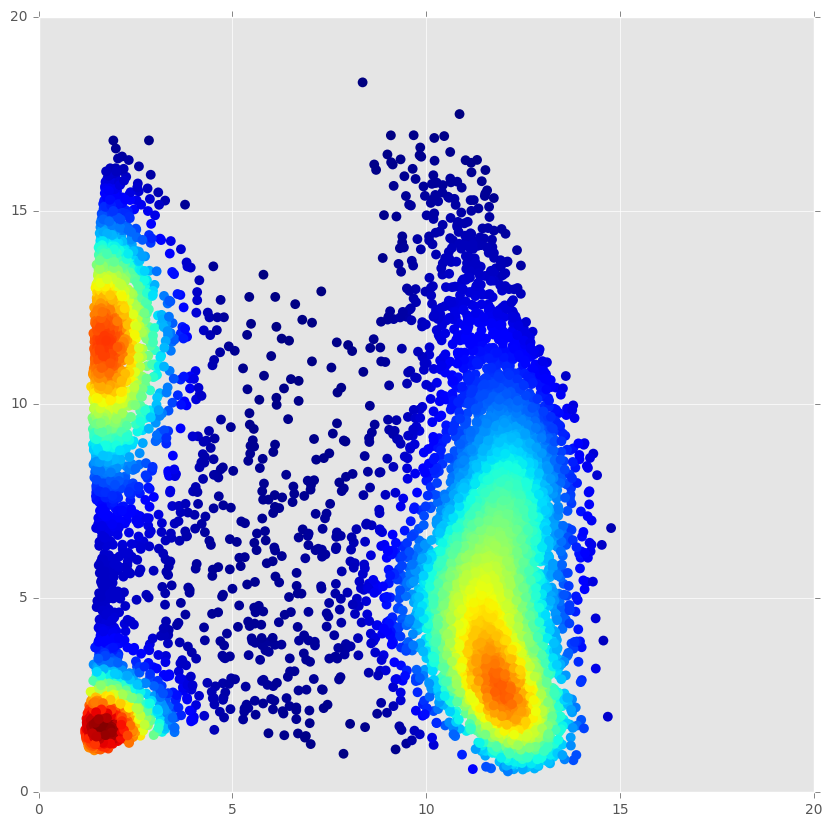

In [3397]:
plot_density(N1, N2,s = 50)
plt.xlim(0,20)
plt.ylim(0,20)

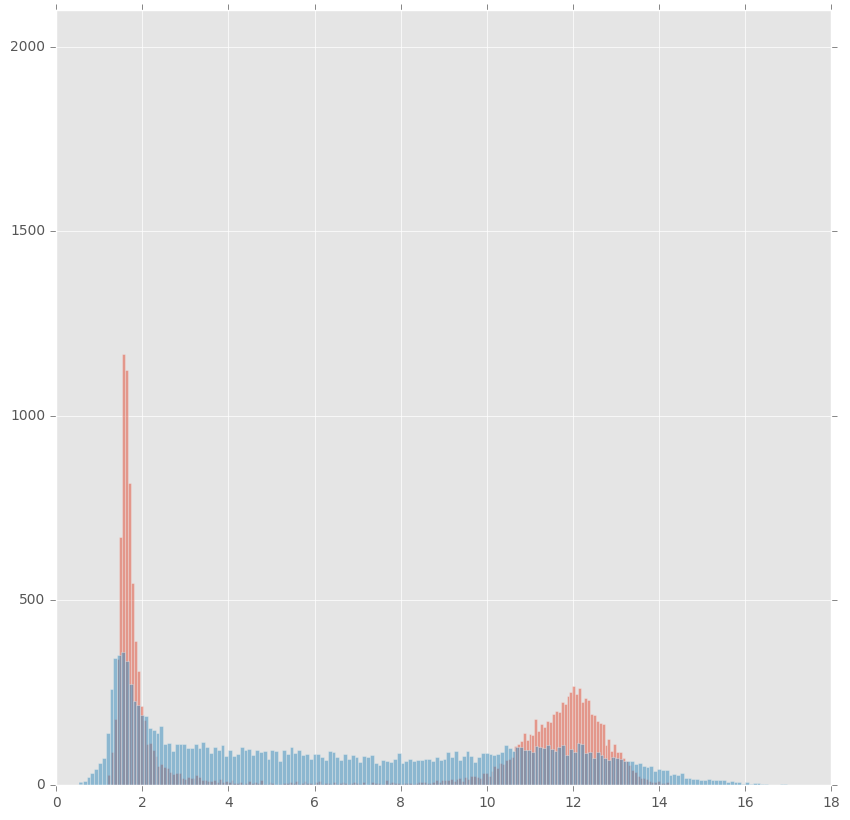

In [3398]:
plt.figure(figsize=(10,10))
plt.hist(N1,bins=200,alpha = 0.5);
plt.ylim(0,2100)
plt.xlim(0,18)
plt.hist(N2,bins=200,alpha = 0.5);

# SLH Driven 2 Kerr

In [3138]:
coherent_2kerr_mcdata_slh = load('coherent_2kerr_mcdata_slh')

In [3057]:
SLH_double_kerr = (KERR_lst[1]  << KERR_lst[0] << Displace(alpha=alpha0)+cid(1)).toSLH()

In [3058]:
H_num_2_slh, L_num_2_slh = SLH_double_kerr.substitute(params).HL_to_qutip()       ## Driven with  alpha0

In [3059]:
coherent_2kerr_mcdata_slh  = qutip.mcsolve(H_num_2_slh, double_psi0, Tsim, L_num_2_slh, 
                       double_obsq, ntraj=Ntraj, 
                       options=qutip.Odeoptions(store_states=False,average_expect=False,seeds = [1],))

10.0%. Run time:  95.46s. Est. time left: 00:00:14:19
20.0%. Run time: 170.89s. Est. time left: 00:00:11:23
30.0%. Run time: 253.12s. Est. time left: 00:00:09:50
40.0%. Run time: 345.39s. Est. time left: 00:00:08:38
50.0%. Run time: 448.21s. Est. time left: 00:00:07:28
60.0%. Run time: 559.20s. Est. time left: 00:00:06:12
70.0%. Run time: 679.47s. Est. time left: 00:00:04:51
80.0%. Run time: 797.75s. Est. time left: 00:00:03:19
90.0%. Run time: 919.02s. Est. time left: 00:00:01:42
100.0%. Run time: 1057.77s. Est. time left: 00:00:00:00
Total run time: 1057.81s


In [ ]:
save(coherent_2kerr_mcdata_slh,'coherent_2kerr_mcdata_slh')

In [ ]:
coherent_2kerr_mcdata_slh = load('coherent_2kerr_mcdata_slh')

In [3144]:
N1s,x1s,p1s,N2s,x2s,p2s  = np.split(np.asarray(coherent_2kerr_mcdata_slh.expect),6,axis=1)
which_trajectories = [i for i in range(0,100)]
min_step = 50 
max_step = 200

N1 = np.concatenate(np.concatenate(N1s[which_trajectories,:,min_step:max_step]))
N2 = np.concatenate(np.concatenate(N2s[which_trajectories,:,min_step:max_step]))

(0, 20)

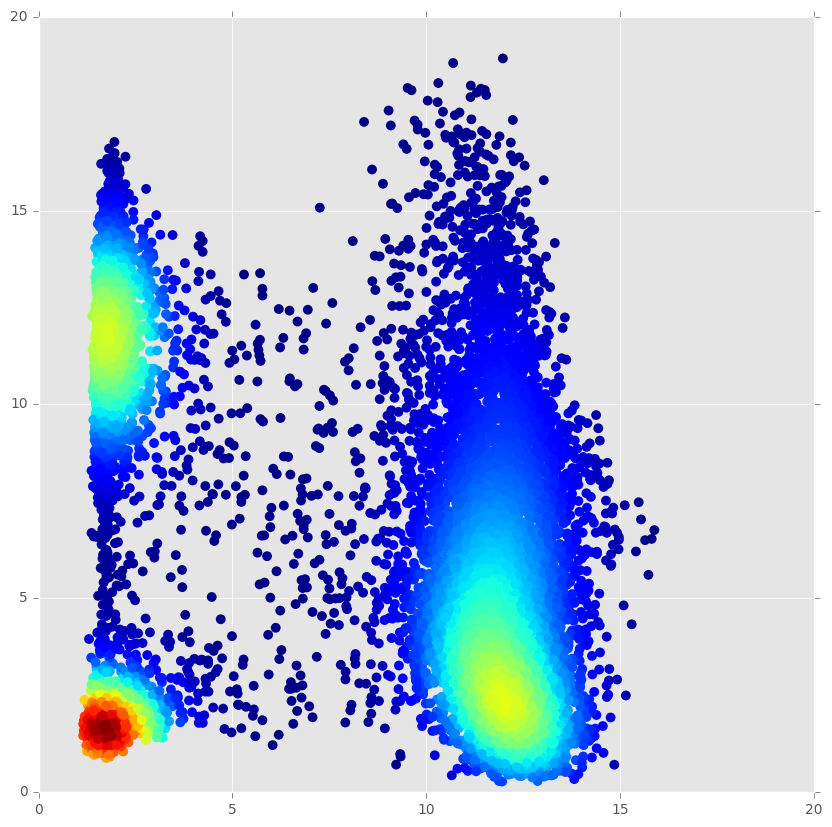

In [3145]:
plot_density(N1, N2,s = 50)
plt.xlim(0,20)
plt.ylim(0,20)

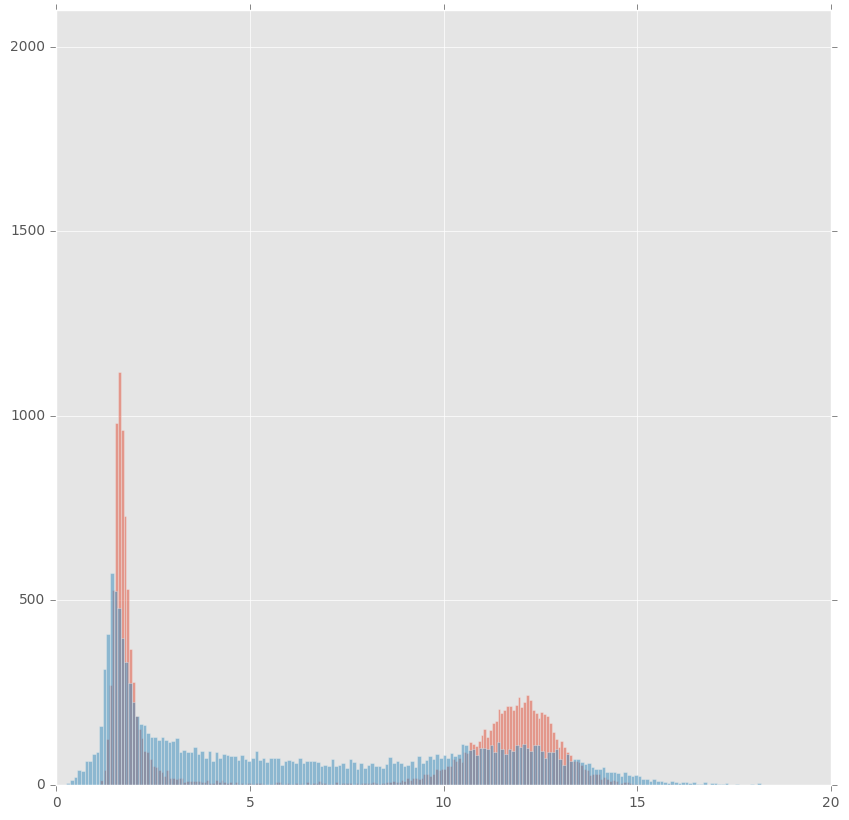

In [3146]:
plt.figure(figsize=(10,10))
plt.hist(N1,bins=200,alpha = 0.5);
plt.ylim(0,2100)
plt.hist(N2,bins=200,alpha = 0.5);

# coherently driven kerr semiclassically feeding into a second kerr

In [3368]:
Ns,xs,ps  = np.split(np.asarray(coherent_kerr_mcdata.expect)[:,:3,:],3,axis=1)

In [3369]:
## Max value for Ntraj_to_use:
Ntraj

100

In [3680]:
semi_2kerr_H_lst = []
semi_2kerr_mcdata_lst = []

Ntraj_to_use = Ntraj

for traj_num in range(Ntraj_to_use):
    ## divide x and p by 2 since a = (x + pi) / 2.
    drive_coeff_x,drive_coeff_p = make_drive_coeffs(params[alpha0]-xs[traj_num][0]/2.,-ps[traj_num][0]/2.,delta_t)
#     drive_coeff_x,drive_coeff_p = make_drive_coeffs(np.zeros_like(xs[traj_num][0])+params[alpha0],np.zeros_like(ps[traj_num][0]),delta_t)
    H_driven_num,L0 = make_driven_model(drive_coeff_x,drive_coeff_p)
    semi_2kerr_H_lst.append(H_driven_num)
    
    semi_2kerr_mcdata_lst.append(qutip.mcsolve(H_driven_num, single_psi0, Tsim,  L0,
                                   single_kerr_obsq, ntraj=1,
                                   options=qutip.Odeoptions(store_states=False,average_expect=False,rhs_reuse=True,
                                   seeds = [traj_num])))

100.0%. Run time:  15.70s. Est. time left: 00:00:00:00
Total run time:  15.79s
100.0%. Run time:  11.00s. Est. time left: 00:00:00:00
Total run time:  11.04s
100.0%. Run time:  10.64s. Est. time left: 00:00:00:00
Total run time:  10.75s
100.0%. Run time:  22.31s. Est. time left: 00:00:00:00
Total run time:  22.35s
100.0%. Run time:  13.43s. Est. time left: 00:00:00:00
Total run time:  13.49s
100.0%. Run time:   9.19s. Est. time left: 00:00:00:00
Total run time:   9.23s
100.0%. Run time:  21.46s. Est. time left: 00:00:00:00
Total run time:  21.50s
100.0%. Run time:   9.82s. Est. time left: 00:00:00:00
Total run time:   9.88s
100.0%. Run time:  16.26s. Est. time left: 00:00:00:00
Total run time:  16.28s
100.0%. Run time:  13.05s. Est. time left: 00:00:00:00
Total run time:  13.10s
100.0%. Run time:  25.69s. Est. time left: 00:00:00:00
Total run time:  25.70s
100.0%. Run time:  15.21s. Est. time left: 00:00:00:00
Total run time:  15.26s
100.0%. Run time:  16.33s. Est. time left: 00:00:00:

In [3681]:
save(semi_2kerr_mcdata_lst,'semi_2kerr_mcdata_lst')

In [3714]:
semi_2kerr_mcdata_lst = load('semi_2kerr_mcdata_lst')

In [3808]:
N2s,x2s,p2s = np.concatenate(
    np.asarray(
        [np.asarray(semi_2kerr_mcdata_lst[i].expect)[0][:3] 
             for i in range(Ntraj_to_use)]),axis = -1)

In [3809]:
# N1s = np.concatenate(Ns,axis = -1)[0]

In [3810]:
N1s = np.concatenate(Ns[:Ntraj_to_use,0,:])

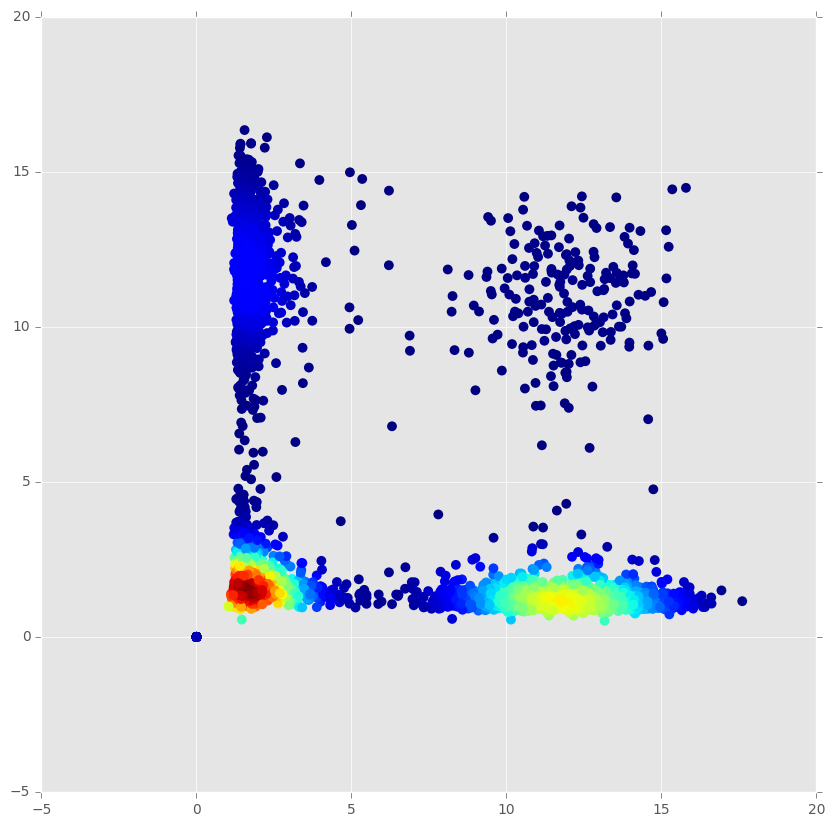

In [3811]:
plot_density(N1s, N2s,s = 50)
# plt.xlim(0,14)
# plt.ylim(0,14)

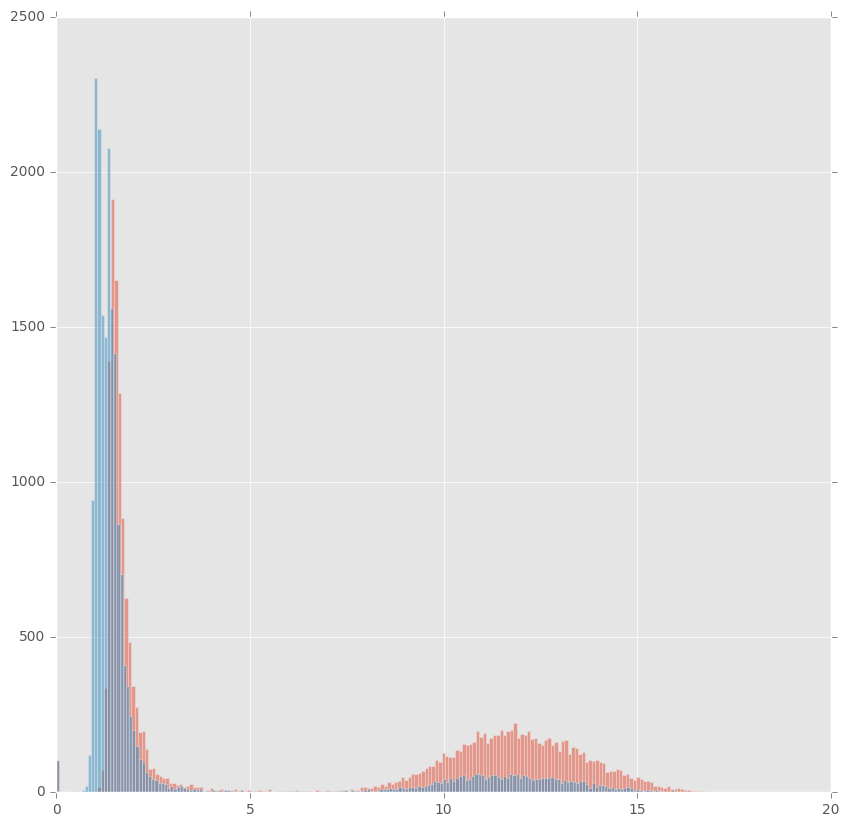

In [3813]:
plt.figure(figsize=(10,10))
plt.xlim(0,20)
plt.hist(N1s,bins=200,alpha = 0.5);
plt.hist(N2s,bins=200,alpha = 0.5);

 # Red(coherently driven Kerr)

In [3768]:
reload(build_markov)

<module 'build_markov' from '/Users/gil/Google Drive/repos/diffusion_maps/build_markov.py'>

In [3769]:
dim_red_coherent_kerr = build_markov.dim_red_builder(Regime= "coherent_kerr",
                                        num_sample_points = 10000,
                                        sample_type = 'last_n',
                                        mcdata = coherent_kerr_mcdata,
                                        obs_indices = [0,1,2],
                                       )

In [3770]:
markov_coherent_kerr = build_markov.markov_model_builder(dim_red_coherent_kerr)

In [3771]:
markov_coherent_kerr.build_model(n_clusters = 10,
                                 which_coords = 'expects',
                                 covariance_type='spherical',
                                 coords_indices_to_use = range(3))

converged True


In [3772]:
markov_coherent_kerr.save()

In [3773]:
markov_coherent_kerr.load()

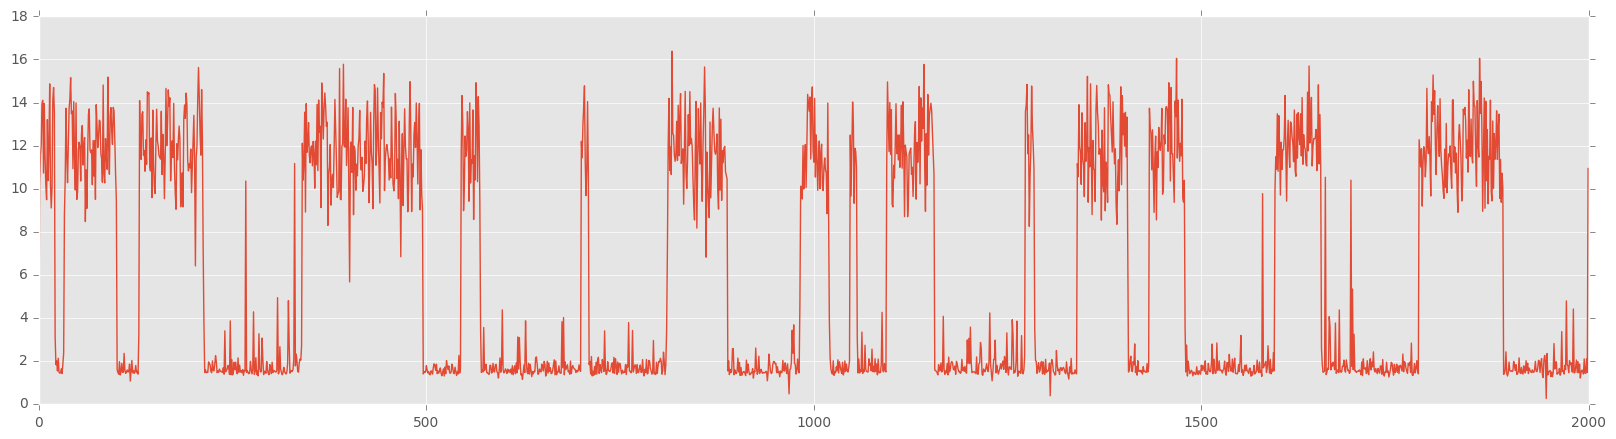

In [3774]:
X,Z = markov_coherent_kerr.hmm_model.sample(2000)
N,x,p = X.T

plt.figure(figsize=(20,5))
plt.plot(N);

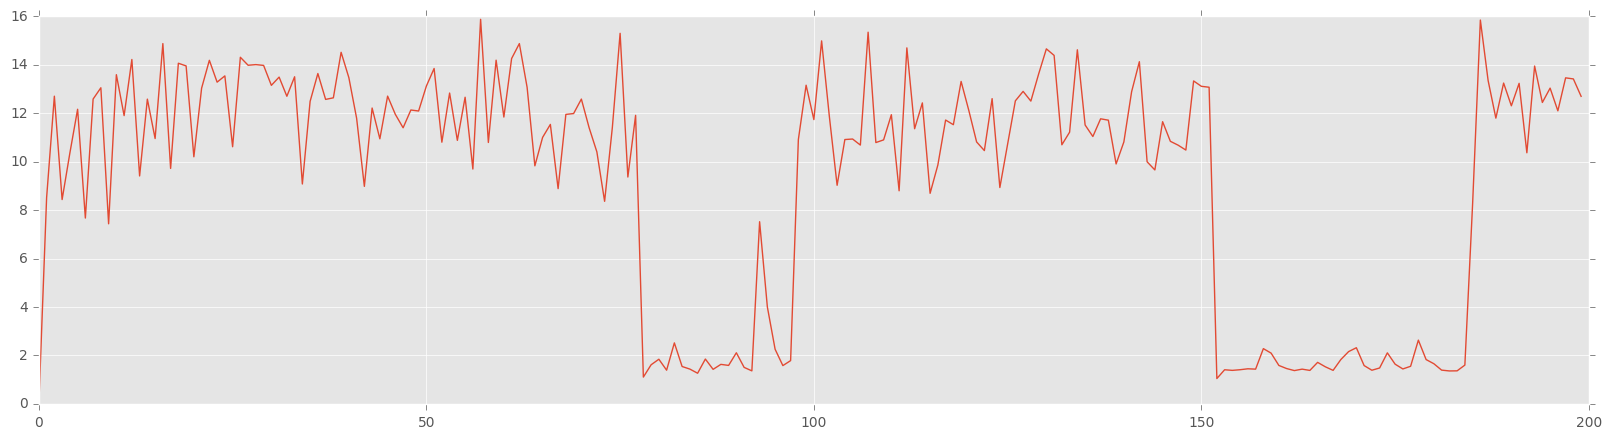

In [3775]:
plt.figure(figsize=(20,5))
plt.plot(np.asarray(coherent_kerr_mcdata.expect)[1,0,:]);

# Red_{12} (coherently driven 2 Kerrs) -- HMM using operators from both Kerrs

In [3336]:
dim_red_coherent_2kerr = build_markov.dim_red_builder(Regime= "coherent_2kerr",
                                                  num_sample_points = 20000,
                                        sample_type = 'last_n',
                                        mcdata = coherent_2kerr_mcdata,
                                       )

In [3337]:
markov_coherent_2kerr = build_markov.markov_model_builder(dim_red_coherent_2kerr)

In [3338]:
# markov_coherent_2kerr.load()

In [3339]:
markov_coherent_2kerr.build_model(n_clusters = 10,which_coords = 'expects',coords_indices_to_use=range(6))

converged True


In [ ]:
markov_coherent_2kerr.save()

In [ ]:
markov_coherent_2kerr.load()

In [3340]:
X,Z = markov_coherent_2kerr.hmm_model.sample(100000)
N1,x1,p1,N2,x2,p2 = X.T

(0, 14)

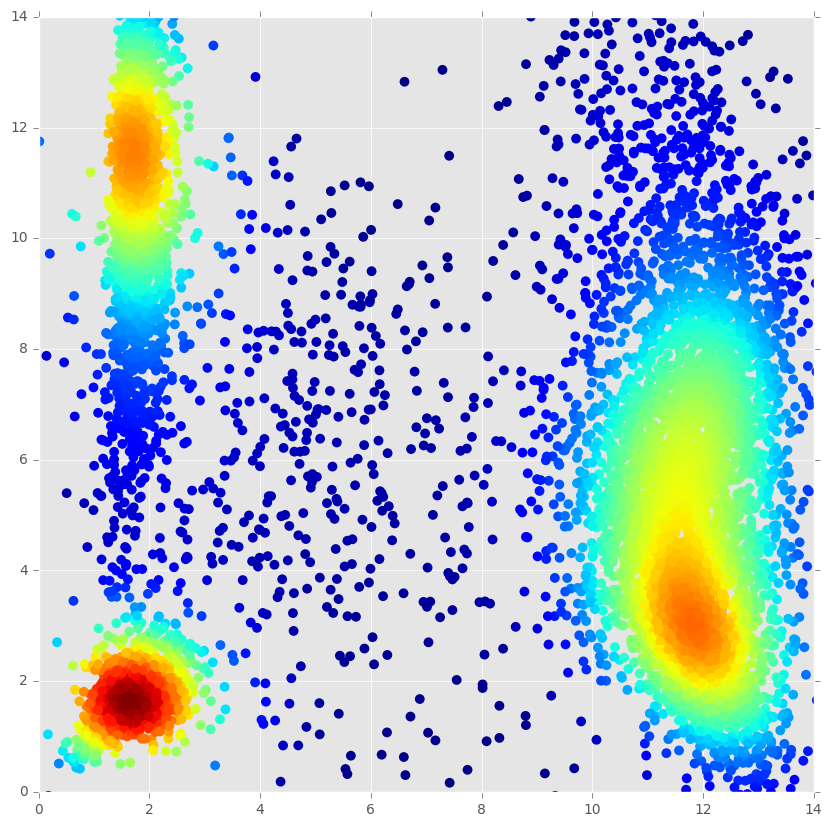

In [3341]:
plot_density(N1, N2,s = 50)
plt.xlim(0,14)
plt.ylim(0,14)

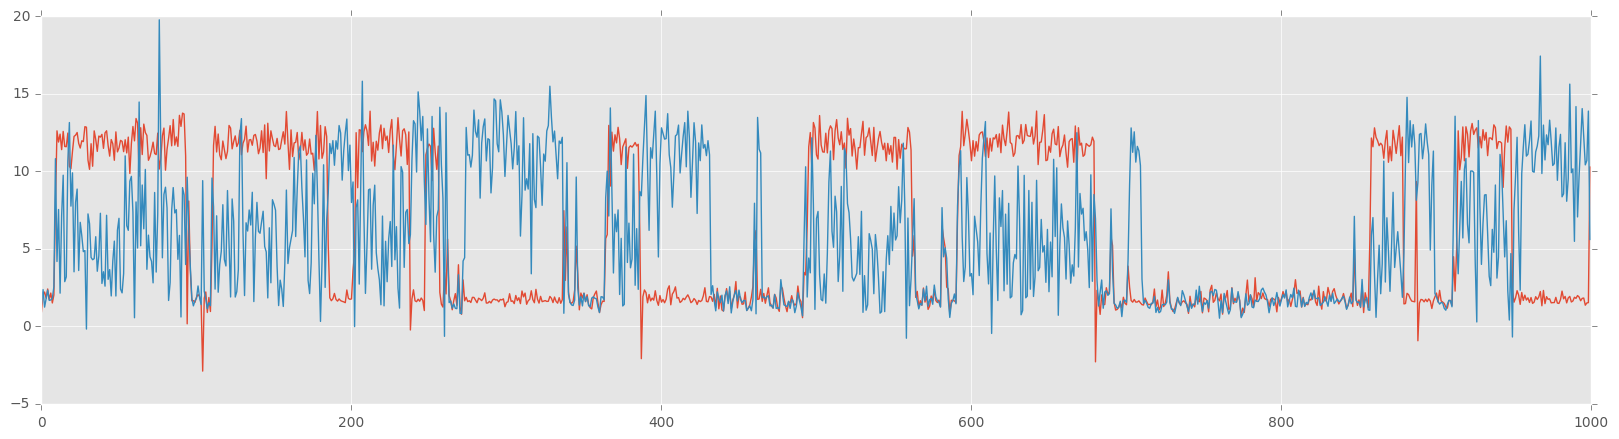

In [3347]:
plt.figure(figsize=(20,5))
plt.plot(N1[:1000])
plt.plot(N2[:1000])

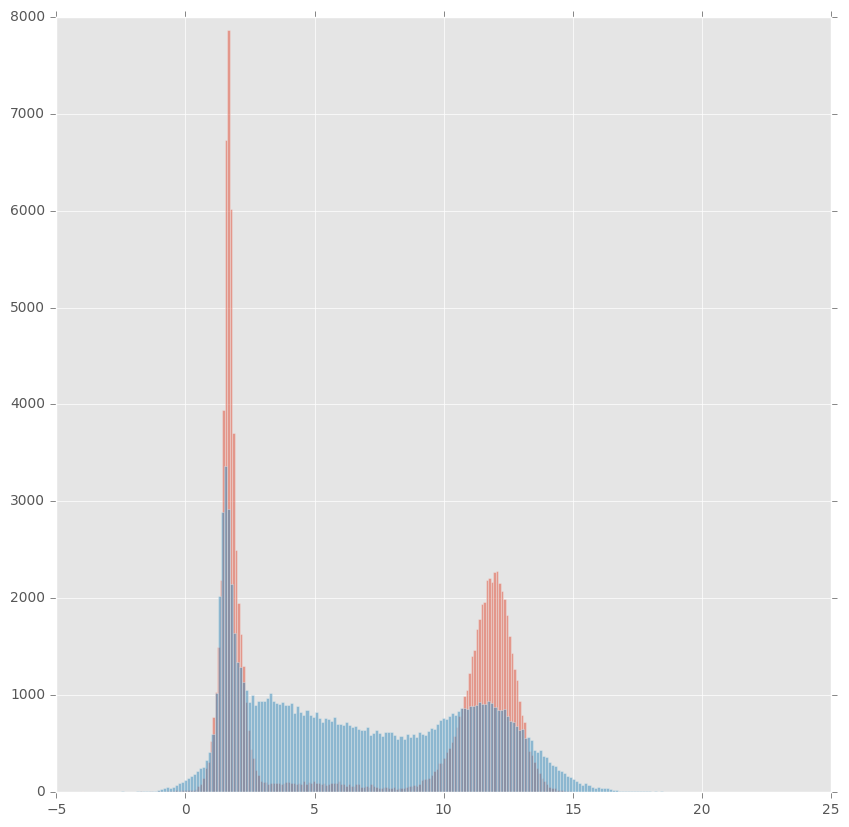

In [3393]:
plt.figure(figsize=(10,10))
plt.hist(N1,bins=200,alpha = 0.5);
plt.hist(N2,bins=200,alpha = 0.5);

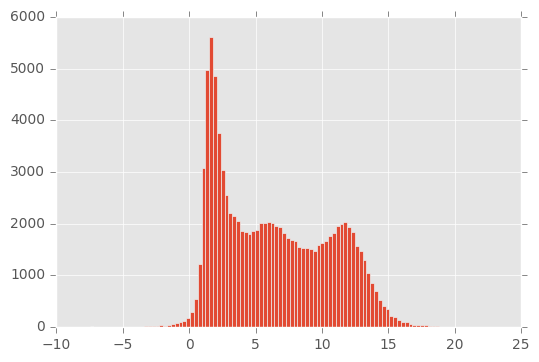

In [3343]:
plt.hist(N2,bins=100);

In [3348]:
# plt.figure(figsize=(20,5))
# plt.plot(np.asarray(coherent_2kerr_mcdata.expect)[0,3,:])

#  Red_{2} (coherently driven 2 Kerrs) -- HMM using operators from the second Kerr only

In [3354]:
dim_red_coherent_2kerr2 = build_markov.dim_red_builder(Regime= "coherent_2kerr2",
                                         num_sample_points = 20000,
                                        sample_type = 'last_n',
                                        mcdata = coherent_2kerr_mcdata,
                                       )

In [3355]:
markov_coherent_2kerr2 = build_markov.markov_model_builder(dim_red_coherent_2kerr2)

In [3356]:
# markov_coherent_2kerr2.load()

In [3357]:
markov_coherent_2kerr2.build_model(n_clusters = 10,which_coords = 'expects',coords_indices_to_use = [3,4,5])

converged True


In [ ]:
markov_coherent_2kerr2.save()

In [ ]:
markov_coherent_2kerr2.load()

In [3358]:
X,Z = markov_coherent_2kerr2.hmm_model.sample(100000)
N2,x2,p2 = X.T

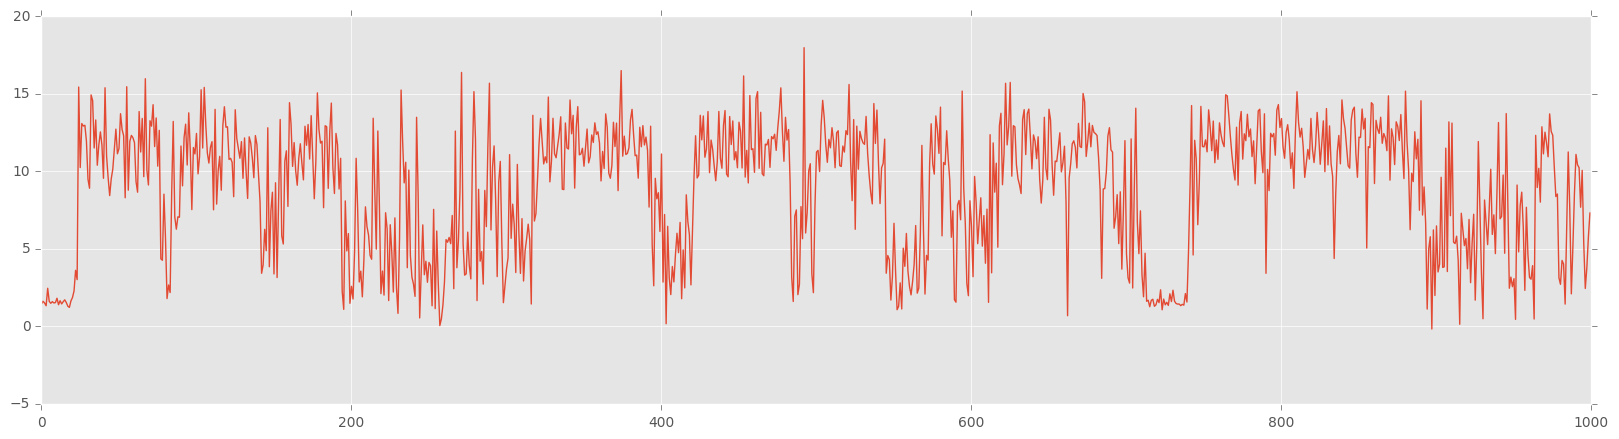

In [3362]:
plt.figure(figsize=(20,5))
plt.plot(N2[:1000])

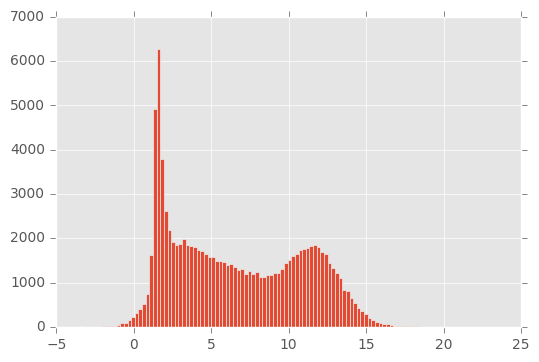

In [3363]:
plt.hist(N2,bins=100);

In [3365]:
# plt.figure(figsize=(20,5))
# plt.plot(np.asarray(coherent_2kerr_mcdata.expect)[0,3,:])

# Red(coherently driven Kerr) feeding semiclassically into second Kerr

Note: The N1,x1,p1 are used in the next section...

In [3634]:
semi_red_H = []
semi_red_mcdata_lst = []

Ntraj_to_use = Ntraj
N2s = []

hmm_sampling = 'hmm_gen'

if hmm_sampling == 'hmm_gen':
    X,Z = markov_coherent_kerr.hmm_model.sample(len(Tsim)*Ntraj_to_use)
    N1,x1,p1 = X.T
elif hmm_sampling == 'hmm_means':
    N1,x1,p1 = markov_coherent_kerr.generate_obs_traj(len(Tsim)*Ntraj_to_use)
else:
    raise ValueError
    
N1s = np.split(N1,Ntraj_to_use)

In [3654]:
for traj_num in range(Ntraj_to_use): ## Ntraj

    ## Important: The semi_red_mcdata_lst below should must be consistent with the N,x,p below 
    ## in order to properly train the next model i.e. Red(Red(kerr) --(semiclassical)-> Kerr)
    
    # save([N,x,p],'coherent_kerr_generated')

    ## divide x and p by 2 since a = (x + pi) / 2.
    drive_coeff_x,drive_coeff_p = make_drive_coeffs(params[alpha0]-x/2,-p/2,delta_t)
    H_driven_num,L0 = make_driven_model(drive_coeff_x,drive_coeff_p)
    semi_red_H.append(H_driven_num)

    semi_red_mcdata_lst.append(qutip.mcsolve(H_driven_num, single_psi0, Tsim,  L0,
                                   single_kerr_obsq, ntraj=1,
                                   options=qutip.Odeoptions(store_states=False,average_expect=False,rhs_reuse=True,
                                   seeds = [traj_num])))
    
    N2,x2,p2 = np.asarray(semi_red_mcdata_lst[traj_num].expect)[0][:3]
    N2s.append(N2)

In [3460]:
save(semi_red_mcdata_lst,'semi_red_mcdata_lst')

In [3640]:
semi_red_mcdata_lst = load('semi_red_mcdata_lst')

In [3641]:
# ## First coordinate of second model is N2
# plt.figure(figsize=(20,5))
# plt.plot(np.asarray(semi_red_mcdata_lst[0].expect)[0,0,:]);

In [3655]:
N1 = np.concatenate(N1s)
N2 = np.concatenate(N2s)

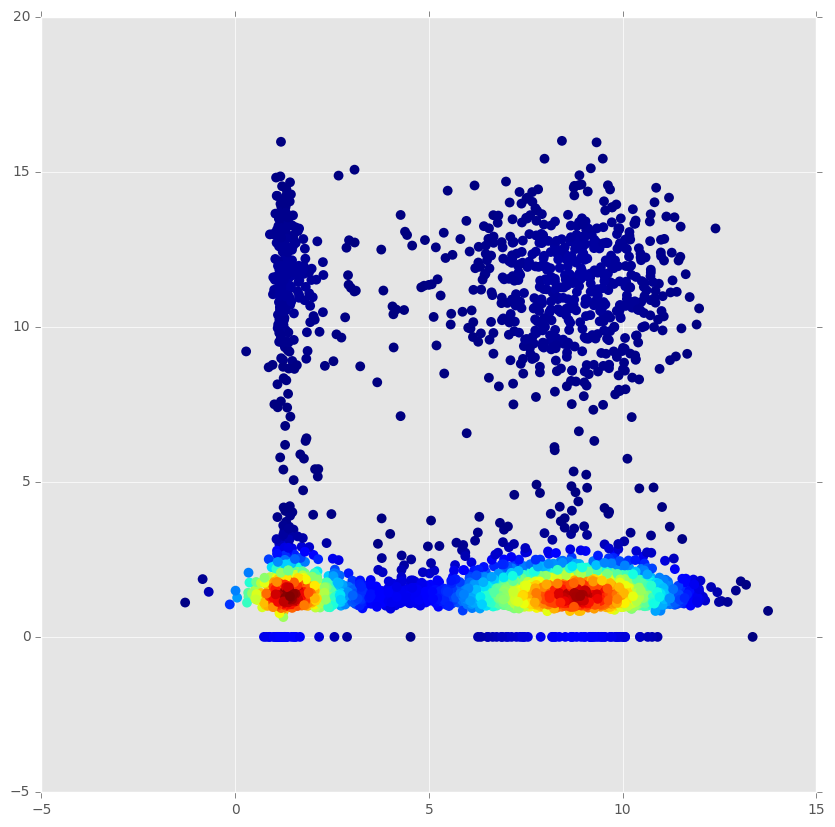

In [3529]:
plot_density(N1, N2,s = 50)

# Red(  Red(coherently driven Kerr) feeding semiclassically into second Kerr ) 


In [3643]:
dim_red_semi_to_kerr = build_markov.dim_red_builder(Regime= "semi_to_kerr",
                                        sample_type = 'all',
                                        mcdata = semi_red_mcdata_lst,
                                        obs_indices = [0,1,2,3,4,5],
                                       )

In [3644]:
markov_semi_to_kerr = build_markov.markov_model_builder(dim_red_semi_to_kerr)

In [3645]:
## train on the first three observables (S1)
## and the expectations of other system.

markov_semi_to_kerr.expects_sampled = np.concatenate([np.asarray([N1,x1,p1]).T,
                                                          markov_semi_to_kerr.expects_sampled[:,:3]],
                                                             axis=-1)

In [3646]:
# markov_semi_to_kerr.load()

In [3647]:
markov_semi_to_kerr.build_model(n_clusters = 10,covariance_type='spherical',
                                which_coords = 'expects',coords_indices_to_use=range(6))

converged True


In [3648]:
X,Z = markov_semi_to_kerr.hmm_model.sample(10000)
N1,x1,p1,N2,x2,p2 = X.T

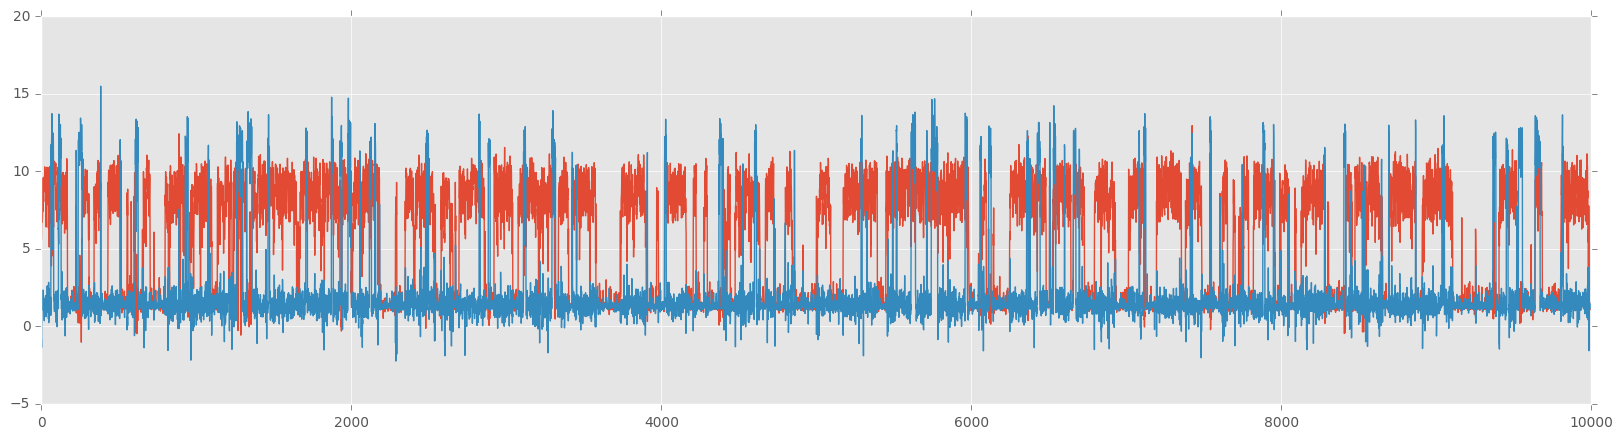

In [3649]:
plt.figure(figsize=(20,5))
plt.plot(N1)
plt.plot(N2)

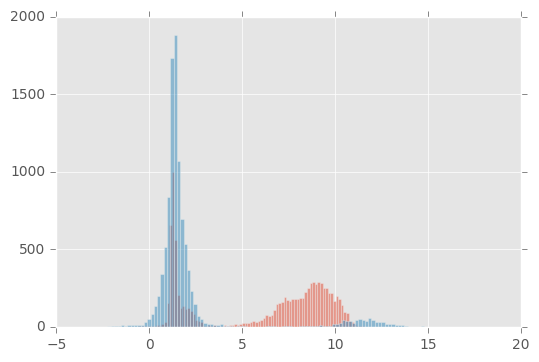

In [3653]:
plt.hist(N1,bins=100,alpha=0.5);
plt.hist(N2,bins=100,alpha=0.5);

(0, 14)

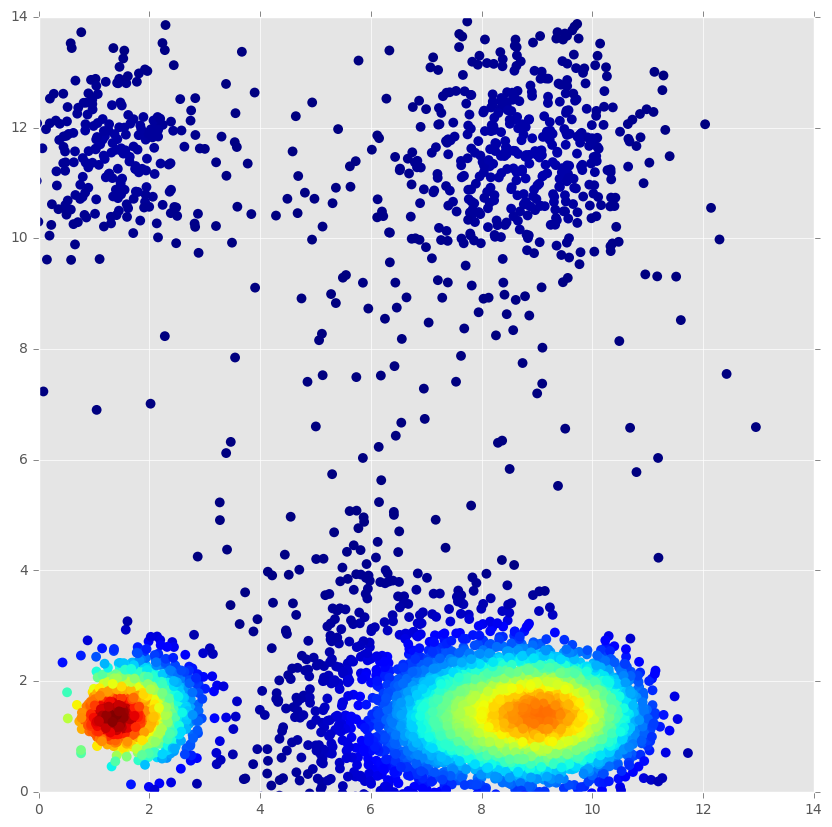

In [3651]:
plot_density(N1, N2,s = 50)

In [3652]:
markov_semi_to_kerr.save()

In [ ]:
markov_semi_to_kerr.load()

# Hybrid Model: red (Kerr1) --> kerr 2

In [3688]:
from sample_systems import make_kerr_slh

In [3690]:
slh_kerr_qnet, a_1_lst = make_kerr_slh(index = 1,which_symbols='qnet',params=params)

In [3691]:
slh_kerr_sympy, sympy_symbols = make_kerr_slh(index = 0,which_symbols='sympy',params=params)
replacement_dict = {symbol : index for symbol, index in zip(sympy_symbols,range(3)) }
slh_12 = (slh_kerr_qnet << slh_kerr_sympy << Displace(alpha=params[alpha0])+cid(1)).toSLH()
slh_12

SLH(Matrix([[1, 0], [0, 1]]), Matrix([[OperatorPlus(ScalarTimesOperator(-2.5*I*p - 2.5*x + 22.0, IdentityOperator), ScalarTimesOperator(5, Destroy(LocalSpace('1', ''))))], [OperatorPlus(ScalarTimesOperator(-2.5*I*p - 2.5*x, IdentityOperator), ScalarTimesOperator(5, Destroy(LocalSpace('1', ''))))]]), OperatorPlus(ScalarTimesOperator(-5.0*N*(N + 1) + 100.0*N, IdentityOperator), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(22.0, OperatorPlus(ScalarTimesOperator(-2.5*I*p - 2.5*x, IdentityOperator), ScalarTimesOperator(5, Destroy(LocalSpace('1', ''))))), ScalarTimesOperator(-22.0, OperatorPlus(ScalarTimesOperator(2.5*I*conjugate(p) - 2.5*conjugate(x), IdentityOperator), ScalarTimesOperator(5, Create(LocalSpace('1', ''))))))), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(25.0*I*p + 25.0*x, Create(LocalSpace('1', ''))), ScalarTimesOperator(25.0*I*conjugate(p) - 25.0*conjugate(x), Destroy(LocalSpace('1', ''))))), ScalarTimesOperator(-5.0, OperatorTimes(Create(LocalSpa

In [3767]:
reload(build_markov)

<module 'build_markov' from '/Users/gil/Google Drive/repos/diffusion_maps/build_markov.py'>

In [3776]:
hybrid = build_markov.hybrid_model(slh_12,markov_coherent_kerr,
                                   replacement_dict,single_kerr_obsq,delta_t, name = 'sys_12')

In [3795]:
Ntraj_12 = 30
hybrid.generate_trajectories(Tsim,Ntraj=Ntraj_12,seeds = range(Ntraj_12) )

100.0%. Run time: 348.78s. Est. time left: 00:00:00:00
Total run time: 348.87s
100.0%. Run time: 356.77s. Est. time left: 00:00:00:00
Total run time: 356.82s
100.0%. Run time: 337.98s. Est. time left: 00:00:00:00
Total run time: 338.01s
100.0%. Run time: 353.27s. Est. time left: 00:00:00:00
Total run time: 353.39s
100.0%. Run time: 344.62s. Est. time left: 00:00:00:00
Total run time: 344.75s
100.0%. Run time: 335.81s. Est. time left: 00:00:00:00
Total run time: 335.92s
100.0%. Run time: 339.67s. Est. time left: 00:00:00:00
Total run time: 339.70s
100.0%. Run time: 332.75s. Est. time left: 00:00:00:00
Total run time: 332.89s
100.0%. Run time: 346.03s. Est. time left: 00:00:00:00
Total run time: 346.15s
100.0%. Run time: 343.28s. Est. time left: 00:00:00:00
Total run time: 343.42s
100.0%. Run time: 319.23s. Est. time left: 00:00:00:00
Total run time: 319.31s
100.0%. Run time: 321.32s. Est. time left: 00:00:00:00
Total run time: 321.39s
100.0%. Run time: 327.53s. Est. time left: 00:00:00:

In [3796]:
sys_12_outputs = hybrid.get_generated_trajs()

In [3803]:
N1,x1,p1,N2,x2,p2 = np.concatenate(sys_12_outputs,axis=0)[:,:6].T

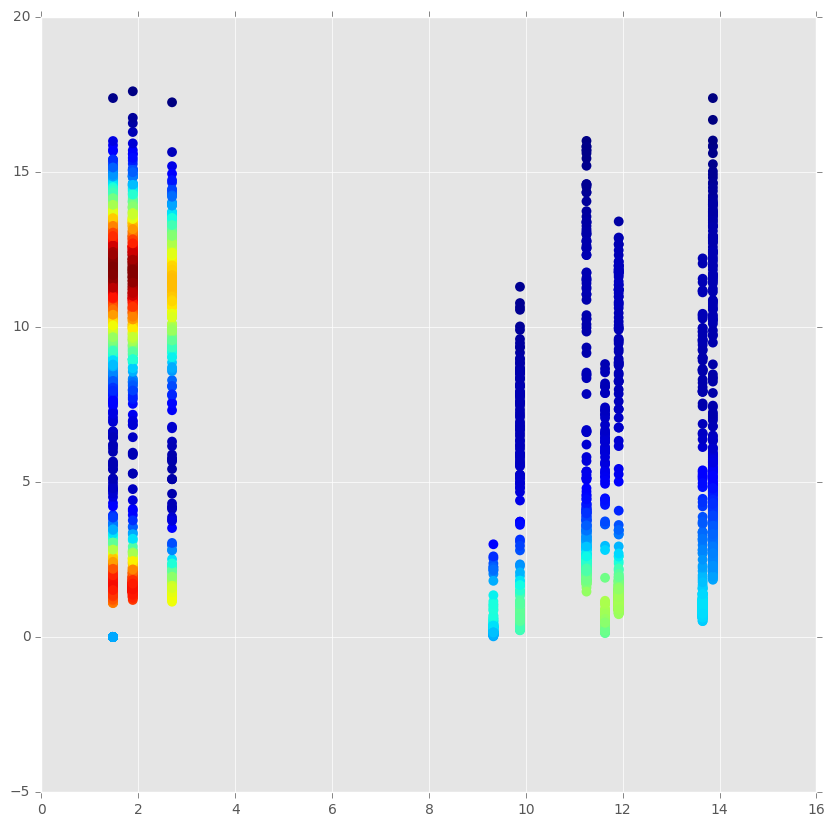

In [3804]:
plot_density(N1, N2,s = 50)

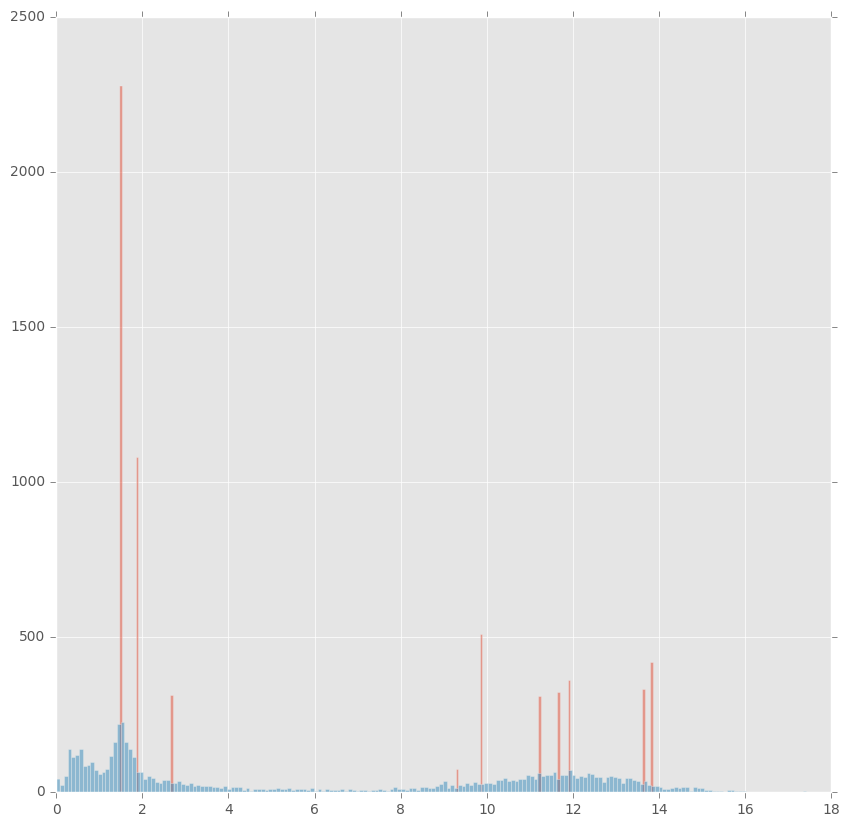

In [3807]:
plt.figure(figsize=(10,10))
plt.hist(N1,bins=200,alpha = 0.5);
plt.hist(N2,bins=200,alpha = 0.5);

In [3806]:
hybrid.save()
hybrid.load()

# Plotting input/output...

In [ ]:
delta = 100
chi = -10

y_= np.linspace(-5,5,200)
x_ = y_**3*chi+y_*delta
plt.plot(x_/2,y_)